In [5]:
import claudio
import librosa
import numpy as np
import os
import pandas
import wcqtlib.config as C
import wcqtlib.common.utils as utils

%matplotlib inline
import seaborn
import mpld3

seaborn.set()
np.set_printoptions(precision=4, suppress=True)
mpld3.enable_notebook()

config = C.Config.from_yaml("./data/master_config.yaml")

In [17]:
extract_path = os.path.expanduser(config["paths/extract_dir"])
datasets_file = config['dataframes/datasets']
datasets_path = os.path.join(extract_path, datasets_file)
datasets_df = pandas.read_json(datasets_path)
notes_df = pandas.read_pickle(notes_path)
notes_file = config['dataframes/notes']
notes_path = os.path.join(extract_path, notes_file)
notes_df = pandas.read_pickle(notes_path)
features_df_fn = config['dataframes/features']
features_path = os.path.join(extract_path, features_df_fn)
features_df = pandas.read_pickle(features_path)

In [16]:
import wcqtlib.data.parse
new_notes_df = wcqtlib.data.parse.normalize_instrument_names(notes_df)
new_notes_df.to_pickle(notes_path)
new_features_df = wcqtlib.data.parse.normalize_instrument_names(features_df)
new_features_df.to_pickle(features_path)

In [18]:
print(notes_df["instrument"].unique())
print(features_df["instrument"].unique())

['tuba' 'flute' 'horn-french' 'trombone' 'clarinet' 'bassoon' 'trumpet'
 'oboe' 'guitar' 'violin' 'cello' 'double-bass']
['horn-french' 'trombone' 'tuba' 'clarinet' 'guitar' 'trumpet' 'flute'
 'bassoon' 'oboe' 'violin' 'cello' 'double-bass']


In [19]:
import matplotlib.pyplot as plt
def viz_audio(record, downsample_rate=150):
    """Plot the audio from a record"""
    audio_path = record["audio_file"][0]
    audio, sr = claudio.read(audio_path, channels=1)
    print("N samples: {}\nDuration: {:.3f}s\nsr: {}".format(audio.shape[0], len(audio)/sr, sr))
    
    plt.figure(figsize=(6, 2))
    print(audio.shape)
    plt.plot(audio[::downsample_rate])
    

def play_audio(record):
    """Play the audio from a record"""
    import claudio.sound
    audio, sr = claudio.read(path, channels=1)
    claudio.sound.soundsc(audio, sr)

    
def viz_features(record):
    """Vizualize the features from a record."""
    import librosa.display
    cqt_path = record["cqt"][0]
    cqt_feats = np.load(cqt_path)['cqt']
    cqt = cqt_feats.reshape((cqt_feats.shape[1], cqt_feats.shape[2]))
    print("CQT Shape:", cqt.shape)
    
    plt.figure(figsize=(8, 4))
#     librosa.display.specshow(cqt, y_axis="cqt_hz")
    plt.imshow(np.log(cqt), aspect="auto", interpolation="none", cmap="OrRd")
    plt.colorbar(format='%+2.0f dB')
    plt.title('Constant-Q power spectrogram (Hz)')

Path: 092CGRFF030.flac from rwc instrument: guitar
N samples: 88200
Duration: 2.000s
sr: 44100.0
(88200, 1)


/Users/cjacoby/miniconda3/envs/ismir2016/lib/python3.5/site-packages/claudio/util.py:42: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return array.reshape([N, channels]) / (2.0 ** (8 * bytedepth - 1))
/Users/cjacoby/miniconda3/envs/ismir2016/lib/python3.5/site-packages/claudio/util.py:42: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return array.reshape([N, channels]) / (2.0 ** (8 * bytedepth - 1))


CQT Shape: (44, 252)


/Users/cjacoby/miniconda3/envs/ismir2016/lib/python3.5/site-packages/claudio/util.py:42: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return array.reshape([N, channels]) / (2.0 ** (8 * bytedepth - 1))
/Users/cjacoby/miniconda3/envs/ismir2016/lib/python3.5/site-packages/claudio/util.py:42: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return array.reshape([N, channels]) / (2.0 ** (8 * bytedepth - 1))
/Users/cjacoby/miniconda3/envs/ismir2016/lib/python3.5/site-packages/IPython/core/formatters.py:92: DeprecationWarning: DisplayFormatter._ipython_display_formatter_default is deprecated: use @default decorator instead.
  def _ipython_display_formatter_default(self):
/Users/cjacoby/miniconda3/envs/ismir2016/lib/python3.5/site-packages/IPython/core/formatters.py:669: DeprecationWarning: PlainTextFormatter._singleton_printers_default is deprecated: use @default decorat

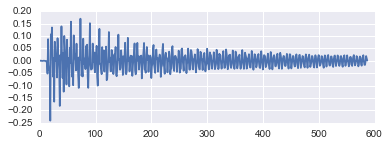

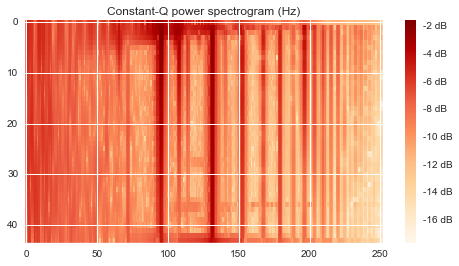

In [20]:
sample = features_df.sample()
path = sample['audio_file'][0]
dataset = sample['dataset'][0]
instrument = sample['instrument'][0]
print("Path:", os.path.basename(path), "from", dataset, "instrument:", instrument)

viz_audio(sample)
viz_features(sample)

play_audio(sample)

In [ ]:
import wcqtlib.data.cqt as cqt
#cqt.cqt_from_df(data_root, extract_path, notes_df_fn, features_df_fn)

In [10]:
def check_instruments(df):
    print(df["instrument"].unique())

In [12]:
check_instruments(notes_df)

['tuba' 'flute' 'french-horn' 'trombone' 'clarinet' 'bassoon' 'trumpet'
 'oboe' 'guitar' 'horn-french' 'guitar-acoustic-steel' 'violin' 'cello'
 'guitar-acoustic-nylon' 'bass-double' 'Violin' 'Bass' 'BbClar' 'Flute'
 'EbClar' 'Trumpet' 'Tuba' 'TenorTrombone' 'Oboe']


In [21]:
np.random.randint(2, size=12)

array([0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0])